## The current notebook uses the red-wine-quality dataset to predict the quality of wine.

The dataset and its description is available here: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

#### The goal of this project is to efficiently predict the quality of wine given the chemical composition.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_red = pd.read_csv("winequality-red.csv")
df_white = pd.read_csv("winequality-white.csv", sep = ';')

In [62]:
df = df_red
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,ok
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df['quality'].value_counts(sort = False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

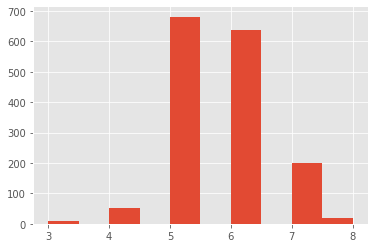

In [63]:
df['quality'].hist()

#### Looks like the distribution is imbalanced, so grouping them into three categories 'good', 'ok' and 'bad'

In [7]:
def gen_labels(df):
    labels = ['bad', 'ok', 'good']
    
    if 1 <= df.loc['quality'] <= 5:
        label = labels[0]
    elif 5 < df.loc['quality'] < 7:
        label = labels[1]
    elif 7 <= df.loc['quality']<= 10:
        label = labels[2]
        
    return label

In [8]:
df['label'] = df.apply(gen_labels, axis = 1)

df['label'] = df['label'].astype('category')

df['label'].value_counts()


bad     744
ok      638
good    217
Name: label, dtype: int64

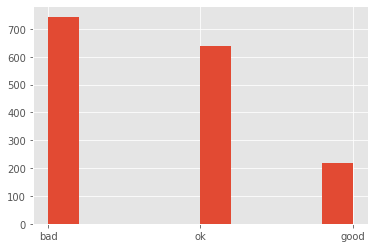

In [9]:
df['label'].hist()

In [10]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [64]:
df.groupby('label').mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
label,,,,,,,,,,,,
bad,8.142204,0.589503,0.237755,2.542070,0.092989,16.567204,54.645161,0.997068,3.311653,0.618535,9.926478,4.901882
good,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049,7.082949
ok,8.347179,0.497484,0.273824,2.477194,0.084956,15.711599,40.869906,0.996615,3.318072,0.675329,10.629519,6.000000


#### Looks like the data is not easily distinguishable, this can be further concluded by some swarm plots

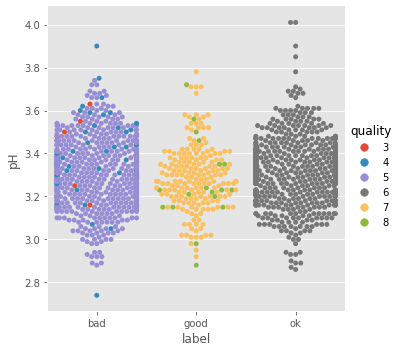

In [12]:
sns.catplot(x='label', y='pH', hue='quality', data=df, kind = 'swarm')

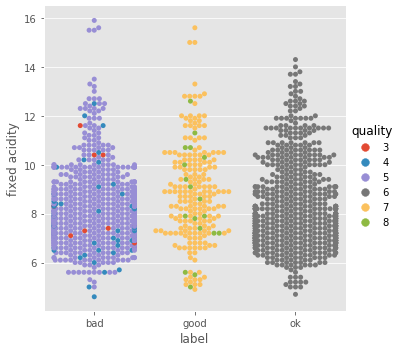

In [13]:
sns.catplot(x='label', y='fixed acidity', hue='quality', data=df, kind = 'swarm')

#### Before staring to build a model and start making predictions, standardizing and splitting the data into training and test set

In [65]:
def scale_and_split(df, test_sizre=0.3):
    
    target = df[['label']]
    features = df.drop(['label', 'quality'], axis = 1)
    labels = list(target.label.unique())
    
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test, labels

In [66]:
def evaluate_model(model, df):
    
    X_train, X_test, y_train, y_test, labels = scale_and_split(df)
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print('Cross validation score - ', scores.mean()*100)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) 
    print('Test accuracy - ',accuracy*100)
    print('Confusion Matrix -\n', confusion_matrix(y_test, y_pred, labels))

In [67]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=42)
rc = RandomForestClassifier(n_estimators=100, max_depth=12 ,random_state=42)

print('\nEvaluation results - Logistic Regression')
evaluate_model(lr, df)

print('\nEvaluation results - Decision Tree Classifier')
evaluate_model(dt, df)

print('\nEvaluation results - Random Forest Classifier')
evaluate_model(rc, df)



Evaluation results - Logistic Regression
Cross validation score -  63.103459320948105
Test accuracy -  60.20833333333333
Confusion Matrix -
 [[172  41   0]
 [ 85 103  12]
 [  4  49  14]]

Evaluation results - Decision Tree Classifier
Cross validation score -  66.13840130970176
Test accuracy -  63.541666666666664
Confusion Matrix -
 [[145  62   6]
 [ 48 126  26]
 [  9  24  34]]

Evaluation results - Random Forest Classifier
Cross validation score -  71.23532635774788
Test accuracy -  70.20833333333333
Confusion Matrix -
 [[167  43   3]
 [ 51 134  15]
 [  1  30  36]]


#### As the data is imbalanced, upmpling the minority class might help increasing the performance of the model.

In [38]:
from sklearn.utils import resample

In [68]:
df_majority = df[df['label']!='good']
df_minority = df[df['label']=='good']
 
df_minority_upsampled = resample(df_minority, replace=True, n_samples=700, random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled['label'].value_counts()

bad     744
good    700
ok      638
Name: label, dtype: int64

In [61]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=42)
rc = RandomForestClassifier(n_estimators=250, max_depth=12 ,random_state=42)

print('\nEvaluation results on upsampled data - Logistic Regression')
evaluate_model(lr, df_upsampled)

print('\nEvaluation results on upsampled data - Decision Tree Classifier')
evaluate_model(dt, df_upsampled)

print('\nEvaluation results on upsampled data - Random Forest Classifier')
evaluate_model(rc, df_upsampled)


Evaluation results on upsampled data - Logistic Regression
Cross validation score -  64.86238874631319
Test accuracy -  60.31999999999999
Confusion Matrix -
 [[169  24  21]
 [ 86  42  67]
 [ 19  31 166]]

Evaluation results on upsampled data - Decision Tree Classifier
Cross validation score -  73.57280369841911
Test accuracy -  72.48
Confusion Matrix -
 [[156  48  10]
 [ 72  99  24]
 [ 13   5 198]]

Evaluation results on upsampled data - Random Forest Classifier
Cross validation score -  78.17340560054672
Test accuracy -  76.32
Confusion Matrix -
 [[171  41   2]
 [ 65 107  23]
 [  3  14 199]]


#### There is a significant improvement in the accuracy of decision tree classifier and random tree classifier after upsampling the minority class.